# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from sentence_transformers import SentenceTransformer
s_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [2]:
# Read it in
path = "../data/surveys_clean_filtered.csv"
df = pd.read_csv(path, na_filter=False)

# Select responses categorized as "about race"
df_race = df[df['about_race'] > 0]

# Group by race
df_race_black = df_race[df_race['racial_group'] == "black"]
df_race_white = df_race[df_race['racial_group'] == "white"]
df_race = pd.concat([df_race_black, df_race_white])

# Get long responses
res_race_black = df_race_black['long'].tolist()
res_race_white = df_race_white['long'].tolist()
res_race = df_race['long'].tolist()

# Embed responses by using the entire response

In [3]:
# Transpose so each column is one response embedding
embed_race_black = np.transpose(s_model.encode(res_race_black))
embed_race_white = np.transpose(s_model.encode(res_race_white))
embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

# Plot singular values

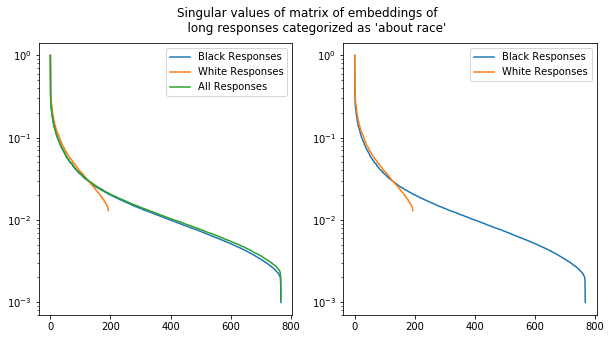

In [4]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle(
    """Singular values of matrix of embeddings of 
    long responses categorized as 'about race'"""
)
    
skip = 0
for A in [embed_race_black, embed_race_white, embed_race]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    S = [S[i]/S[0] for i in range(len(S))]
    axs[0].semilogy(S)
    if skip != 2:
        axs[1].semilogy(S)
    skip += 1
        
axs[0].legend(["Black Responses", "White Responses", "All Responses"])
axs[0].yaxis.set_tick_params(labelleft=True)
    
axs[1].legend(["Black Responses", "White Responses"])
axs[1].yaxis.set_tick_params(labelleft=True)

# CUR Decomposition

In [5]:
# Modified CUR which only selects columns.
# Does not compute the U or R
def cur(A, idx=False, SVD=None, rank=None, p_C=None, use_random=False):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, p=None):
        if not p:
            p = []
            p.append(np.argmax(np.abs(M[:,0])))
        for i in range(len(p),rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = random.sample(range(np.shape(A)[1]),rank) if use_random else DEIM(np.transpose(Wt), p_C)
    C = A[:,p_C]
    
    return (C,p_C) if idx else C

In [6]:
# Using DEIM selection
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

# Using random selection
C_race_black_random, p_C_race_black_random = cur(embed_race_black, idx=True, use_random=True)
C_race_white_random, p_C_race_white_random = cur(embed_race_white, idx=True, use_random=True)
C_race_random, p_C_race_random = cur(embed_race, idx=True, use_random=True)

# Is DEIM biased towards responses with more sentences?

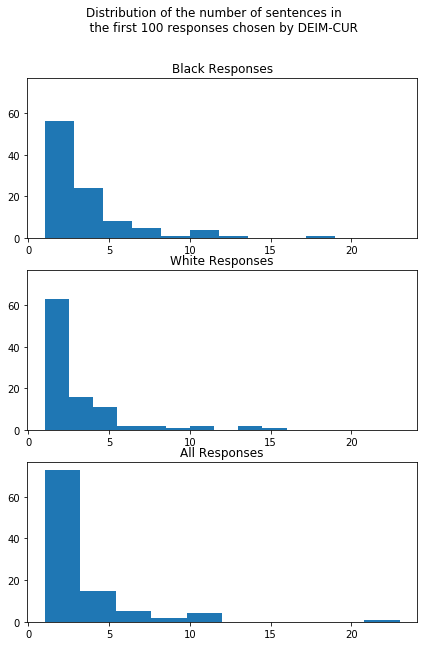

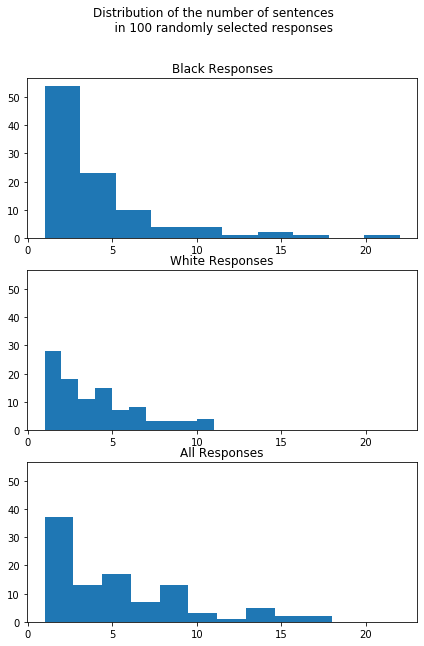

In [7]:
def plot_sentence_lengths(ax, res, p_C, title):
    ax.hist([
        len(list(filter(None, re.split("[.?!][ ]", res[i].strip()))))
        for i in p_C[:100]
    ])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_title(title)

# DEIM Selection
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

plot_sentence_lengths(axs[0], res_race_black, p_C_race_black, "Black Responses")
plot_sentence_lengths(axs[1], res_race_white, p_C_race_white, "White Responses")
plot_sentence_lengths(axs[2], res_race, p_C_race, "All Responses")


# Random Selection
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences 
    in 100 randomly selected responses"""
)

plot_sentence_lengths(axs[0], res_race_black, p_C_race_black_random, "Black Responses")
plot_sentence_lengths(axs[1], res_race_white, p_C_race_white_random, "White Responses")
plot_sentence_lengths(axs[2], res_race, p_C_race_random, "All Responses")

# Error Plots

In [12]:
def plot_error(A, title, axs=None):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    print("Rank:", rank)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    norm_random = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = [] # track pre-selected columns from previous iterations
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2]
        
        C_k, p_C_k = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, p_C=p_C_k)
        C_k_random, p_C_k_random = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, use_random=True)
        
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]        
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
        X_k = np.linalg.pinv(C_k) @ A
        X_k_random = np.linalg.pinv(C_k_random) @ A
        
        norm[k] = np.linalg.norm(A - C_k@X_k)
        norm_random[k] = np.linalg.norm(A - C_k_random@X_k_random)
        
        sig[k] = np.linalg.norm(A - A_k)
        
        if k%100==0:
            print("Progress:",k,"/",rank)
            
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(title)
    
    axs[0][0].scatter(range(rank), eta_c)
    axs[0][0].scatter(range(rank), norm)
    axs[0][0].scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='g')
    axs[0][0].set(xlabel='k')
    axs[0][0].legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])
    axs[0][0].set_title('Using DEIM selection')
    
    axs[0][1].scatter(range(100), (norm[:100]-sig[:100])/sig[:100])
    axs[0][1].set(xlabel='k')
    axs[0][1].legend(["(|| A - C_k(X_k) || - sigma_(k+1)) / sigma_(k+1)"])
    axs[0][1].set_title('Using DEIM selection')
    
    axs[1][0].scatter(range(rank), norm_random)
    axs[1][0].scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='g')
    axs[1][0].set(xlabel='k')
    axs[1][0].legend(["|| A - C_k(X_k) ||", "sigma_k"])
    axs[1][0].set_title('Using random selection')
    
    axs[1][1].scatter(range(100), (norm_random[:100]-sig[:100])/sig[:100])
    axs[1][1].set(xlabel='k')
    axs[1][1].legend(["(|| A - C_k(X_k) || - sigma_(k+1)) / sigma_(k+1)"])
    axs[1][1].set_title('Using random selection')

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 194
Progress: 0 / 194
Progress: 100 / 194
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


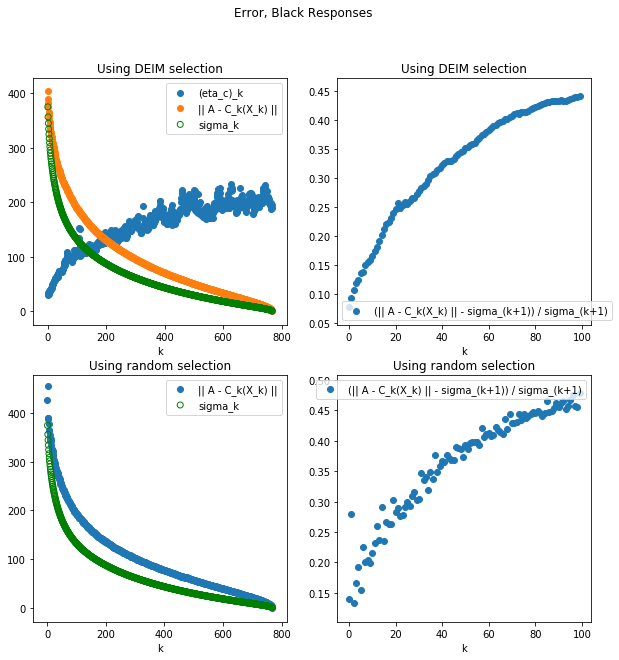

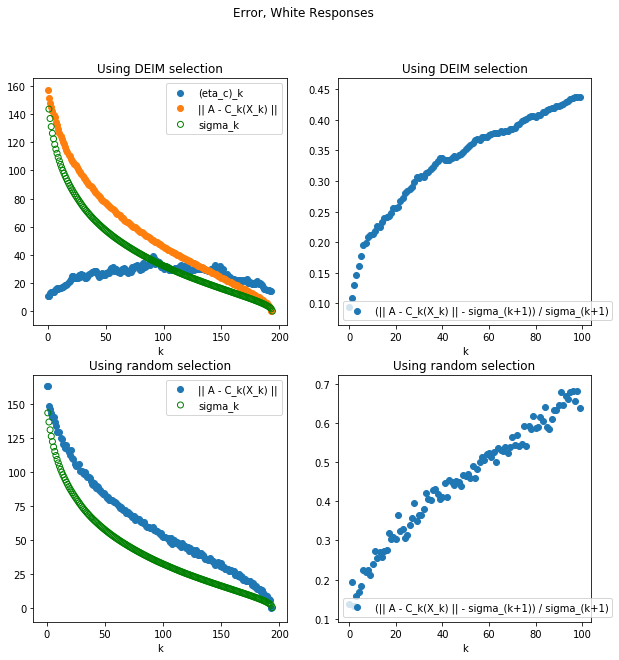

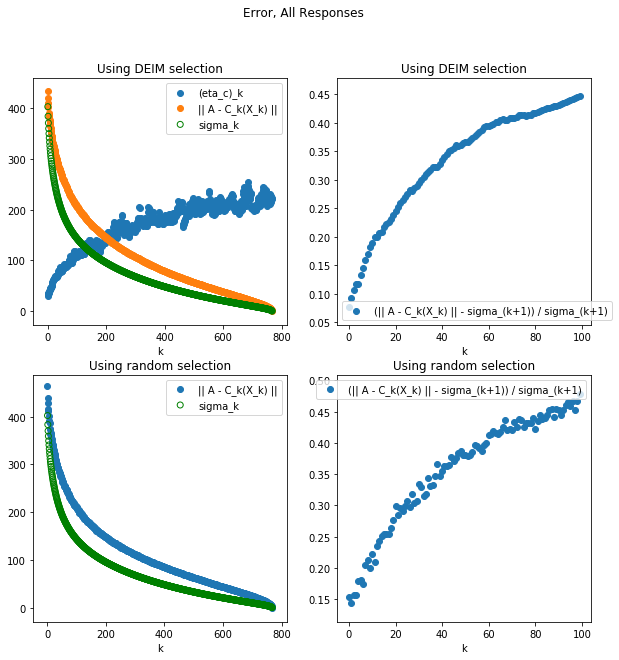

In [13]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")